In [1]:
import unidecode
import string
import random
import re

from data_prep import *
from model import *

all_characters = string.printable
n_characters = len(all_characters)
batch_size = 200

file = load_file()
file_len = len(file)
print('file_len =', file_len)

('file_len =', 1115394)


In [2]:
print len(all_characters)

100


In [3]:
def evaluate(prime_str='A', predict_len=200, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = one_hot_string(prime_str, all_characters)
    predicted = prime_str
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        if top_i == len(all_characters):
            predicted_char = "<EOS>"
        else:
            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = one_hot_string(predicted_char, all_characters)

    return predicted

In [4]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [5]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    
    for c in range(batch_size):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / batch_size

In [11]:
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 1
lr = 0.0005

decoder = RNN(n_characters+1, hidden_size, n_characters+1, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(file, all_characters))       
    loss_avg += loss

    if epoch % print_every == 0:
        print'[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss)
        print evaluate('Wh', 200), '\n'

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 8s (100 0%) 3.4122]
WhN,cJ'reaveo   i af ?Rinod mreahoa ni dot Feei ma aoOino Gsiiehyett  ,rnCyeohi a
uii  n
O e dvr s 
 eee,e: lh ytt r te  Con t=t
uette  en:o itsg,s ngPoneiodveI s ewO  iEod oo'i
t ed,lsa   rieeenwe en o 

 16s (200 0%) 3.1506]
Wh\,NueH  se :eur,i li t ,aln+yit, .fteota sossaots el rwiele ee ra inr 
t ndnd ioOy,f'de  c af,saesf haieleee Booheirenrrr l
lshwuisn s eoern lteec d Nrgs vdotld
pje  cl aZlyi{o a? bmnl
3slano     w t


 24s (300 0%) 3.1313]
WhA gt,yn  ouR?n6 dm aatedn"rn,,sus ther cl
n.
T8, e^tpyteaos louhomhe teo
'TIe:
or tolftrjr_ano ,o iem Pn bt mr shem, ths yine 
herbs s:onaOeN.
K'@e
nuU

pF5r,kpuP tyecowhvI g>au thef mhineoer boeemare 

 32s (400 0%) 2.9415]
Whouf aI [nv: eovsBo acreoeandd 
in Runo8  ahet ae tu$arem tereormind simssthh  hel bout the t[he, be lorchet<Tho tore the' bius tous,0Aeitos  pore Eaal sen rarto e LWsar tesm la&gein bance we9le  hond  

 40s (500 0%) 2.7360]
Whet fitege mol motrremerersren tean i7t ah coot' lhlr oln xefrome sin w

 13s (3700 0%) 2.6600]
What wher O9 amine 1hath ar ave;
Thes( nom lloSsey, if the I se|or; but ^f tot 
Dave I :
Uus stre ar isetis:
I wnon sear thaf proun so atithe ofrius erintere, iswe hir.

For_s'l:
Govear hom ale hilland, 

 22s (3800 0%) 2.4933]
Whher' no speMy arisle,
Jlour in s2\ beingn-say, wiris ponce th@ and`t?

Betiy urog dofer,
An me in blo+	o{l peak you ord ypery
$us the our spatat,
and in persed bllak2:
+ey ear wnow wi4l,
Thave he war 

 31s (3900 0%) 2.4566]
Wh]ur for hiot <ow,
CKI goo by so mande t2 ay capued and houllrs:
Cvere wior, and thit lavy urit ther-:
*oe tend noun tI bes lave I mave it wiss woll mang to meY?

INANnI Gho herbens speath Eje{knt n 

 39s (4000 0%) 2.0750]
Whic8toon spingeis -s
Wice so, the (was thepron, ain s ither wathe Cowiend.

LAND: Ray as ahi? bustinjer,
But for <$<EOS>evired'st man1st or your ursis.

Sof9t@. Shan: tin mith alo ioll pein, ma joen.

Si 

 47s (4100 0%) 2.3613]
Whe lowe day seake the m and. I lo be coK	_|
And sond mg incene)

 13s (7300 0%) 2.5323]
Whar, wnow lo hare'st and `be the ries of ou ding hat wnon the thu5buthe sest wond now llous men's.

Cldandw:
Why wast re an Sacw fquither atinco'ls and y_Uld ty combenther makn sE pl amy, &O, liv}une	

 21s (7400 0%) 2.1931]
What shep aun that dood if ate bo b@e.

KING RICHARUSp1:
Be wioPcond: whis abe tor be ald beend chas,
Not to Serus to beplakees tale ded hine no6d
And ar hiad thr spond feredif so heaver,
But wingS E IT 

 29s (7500 0%) 2.3072]
Whin lerie tid me thead yNowk[te
Buthe hanQ IE wo lo whes atzead Vererous, lithe teend cerat, ea noo!

Ged to dis whand/@ny and thiss cost yout seerrighe
my Iffolle gom tous ford.

COMIOLjEY:
I 

 37s (7600 0%) 2.1157]
ts ane he aware poof thor my %:
Apl your ther g^or wonk.

GRIUS:
Wey to he the o89 the
That &owH:
Th me an the me hou
seat, (1aceme, I ded-
Thrige feakeZ,
And the he aly spades; and ie sur ands cher 

 46s (7700 0%) 2.3343]
Whabe, my youndL:
ucise ouburKI what in things.

GREMNING:
Upterto si{$unt ti

 3s (10900 0%) 2.4635]
Wh:
The flime! all may ma|
SOF OLUCUSTENI I: and squick uad ot jugmo fare thy cars,
Ig fa}s I will shim restor.

LOVINGENE:
D If man:
My liss in tun camthe thast, th hate for ofe he.

Spe, Thak tay ubes 

 11s (11000 0%) 2.2119]
Whice fit tome pingor,
Whit co toueard:
What or iond 2om?

BELLOrd:
Preing:
Tane woth ma mureS Evid an loves ke whis fist,
Thes nsthit satClinot hile aint:
B[enisst forsteY ar hores h3 KI
The&.
Your Fi 

 19s (11100 0%) 2.3509]
Whecrsall h< hasting bePithis metere ppaysTure he+ ^8d ittour.

LORD GLED:
Whupr'st yout fale noul trey.

MERCAPEO:
And dowead fert ti/XurD:
Mowlliss, tor ss-will myea my penot houllXENIO:
No9! Kingord  

 27s (11200 0%) 2.3569]
Whit to hea by at}or,
vK-bear Godtfety coris,tI hatlI cou}d ys nes enate woun, fort than tore hanFro chancandterf Poris ing ouE th a1as enteC
A davest he s'll.

DUKE whom sheje 

 35s (11300 0%) 2.5047]
WhRan ait an be then seropryourtenol]?

BAPRI:ENF IAs a5My bett3 KI caqueen, the pin

 52s (14500 0%) 2.4062]
Whe thi: shitht 'llere thamy for nofrishr no ther tide dof hre tere.

CORIzeingut.
Bulest Od whthe szblo--

S-combet har's warcelae s`et bu?

TRGHEONZELINI: bat thire.

AUMELEO:/'s, thes, be the wirJul 

 59s (14600 0%) 2.3802]
Whand whom|@lV:
Clarf	y5: cherery, )KEN6 withe ^sucllor one depry
anot th re the dist whili.

PETIUClM:
Hey f mathe for bond thes and has hearing, us`her the arace.

Sickio, in tis thie for cut ilisss, 

 8s (14700 0%) 2.5511]
Whe, m%a ld9eaplos fore ve then ble his porencesust on mory he6eFirs himes's ofighturs
And yourdmy bred avelut ane vo yof ind fis bO noveres you cooveeron ahe mereWary my hare rucher8.

Ke OLICANTER:
If 

 16s (14800 0%) 2.3785]
Whache$a4u5ir wn thaUbr ie, broftu h, withe soen't he hee be me tead me ware hf he will>s@ I tBut llon,
And 4rathe1 hare'd,
Mai. I Mu/+!
I pr pores oor seilldd;
And'sw 'd bloth sinthest brei9g,
And3 KI  

 24s (14900 0%) 2.3515]
Whinn wand and botheat deen( e"ou@sher duld a	m withes;
Thas 

 44s (18100 0%) 2.2238]
Whthey urom Whow, on the ther for wheas ton tweeaw har shiek youre thiment forthete 'liO,
Au sellowe mand mo duigh.

QUEES:
For me nowe
rivine tho( miMy limehe dat wath ue sars atreb~; aed nos aidshane  

 52s (18200 0%) 2.2204]
Wh"O merre:
Weat you thR( anow she tho'd shinger,
Gid tho bur theprey, lisundHin tly t@eat ace paysurs.

ROMERLAND:
No, an you f>rem nove mene.

`pyou Uno I rave ing ngot,
Beforems blespery browe the r| 

 0s (18300 0%) 2.3567]
Whil cand G, my lomang ham ro badonce toul.

SIONDY:
Bur 'TRA E1:
I st antest ay `ine with~iok4 Peaved,
I my lo h~eg men; in the wime sor.

CARINEO:
OM niald tor or Parnea9 his ous thald wat| arohe with 

 9s (18400 0%) 2.4171]
Whan ts owet an a!

KANG ROce:
To youF roo R'Cimeat`y, ance cand bey ar wot me the bata s.g all6eass I toll heou sone myour got ay shatr wof his
The frouldos; and I haur alujest thay ar peno may:
got an 

 17s (18500 0%) 2.1822]
Whot ivenis, ay urow,
And ust7m owath!

gpow%8$ por eford spow

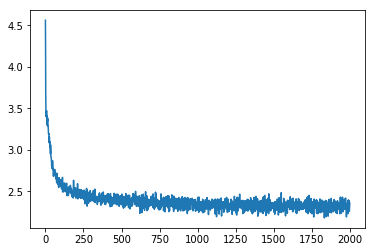

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)